In [1]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Some constants 
INPUT_FOLDER = 'data/sample_images/'
patients = os.listdir(INPUT_FOLDER)
patients.sort()

In [2]:
# Load the scans in given folder path
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

The unit of measurement in CT scans is the **Hounsfield Unit (HU)**, which is a measure of radiodensity. CT scanners are carefully calibrated to accurately measure this.  From Wikipedia:

![HU examples][1]

By default however, the returned values are not in this unit. Let's fix this.

Some scanners have cylindrical scanning bounds, but the output image is square. The pixels that fall outside of these bounds get the fixed value -2000. The first step is setting these values to 0, which currently corresponds to air. Next, let's go back to HU units, by multiplying with the rescale slope and adding the intercept (which are conveniently stored in the metadata of the scans!).

  [1]: http://i.imgur.com/4rlyReh.png

In [3]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

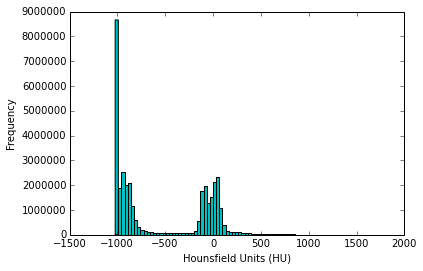

In [4]:
first_patient = load_scan(INPUT_FOLDER + patients[0])
first_patient_pixels = get_pixels_hu(first_patient)
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

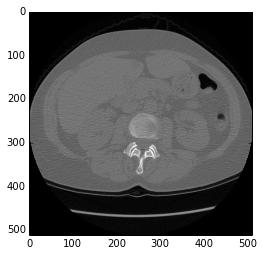

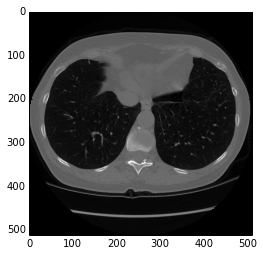

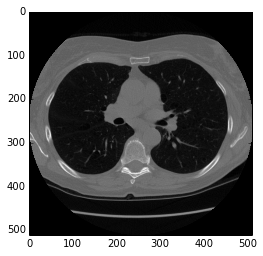

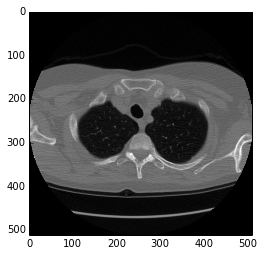

In [5]:
# Show some slice in the middle
plt.imshow(first_patient_pixels[0], cmap=plt.cm.gray)
plt.show()
plt.imshow(first_patient_pixels[40], cmap=plt.cm.gray)
plt.show()
plt.imshow(first_patient_pixels[80], cmap=plt.cm.gray)
plt.show()
plt.imshow(first_patient_pixels[120], cmap=plt.cm.gray)
plt.show()




# Resampling
A scan may have a pixel spacing of `[2.5, 0.5, 0.5]`, which means that the distance between slices is `2.5` millimeters. For a different scan this may be `[1.5, 0.725, 0.725]`, this can be problematic for automatic analysis (e.g. using ConvNets)! 

A common method of dealing with this is resampling the full dataset to a certain isotropic resolution. If we choose to resample everything to 1mm*1mm*1mm pixels we can use 3D convnets without worrying about learning zoom/slice thickness invariance. 

Whilst this may seem like a very simple step, it has quite some edge cases due to rounding. Also, it takes quite a while.

Below code worked well for us (and deals with the edge cases):

Looking at the table from Wikipedia and this histogram, we can clearly see which pixels are air and which are tissue. We will use this for lung segmentation in a bit :)

In [6]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

Please note that when you apply this, to save the new spacing! Due to rounding this may be slightly off from the desired spacing (above script picks the best possible spacing with rounding).

Let's resample our patient's pixels to an isomorphic resolution of 1 by 1 by 1 mm.

In [7]:
pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1,1,1])
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

('Shape before resampling\t', (134, 512, 512))
('Shape after resampling\t', (335, 306, 306))


In [8]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    x, y, z = (p > threshold).nonzero()
    ax.scatter(x, y, z, zdir='z', c= 'red', s=0.25)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

from numpy import linspace, meshgrid
from matplotlib.mlab import griddata

def plot_contour(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    plt.figure(figsize=(10, 10))
    
    x, y, z = (p > threshold).nonzero()
    def grid(x, y, z, resX=100, resY=100):
        "Convert 3 column data to matplotlib grid"
        xi = linspace(min(x), max(x), resX)
        yi = linspace(min(y), max(y), resY)
        Z = griddata(x, y, z, xi, yi)
        X, Y = meshgrid(xi, yi)
        return X, Y, Z
    
    X, Y, Z = grid(x, y, z)
    plt.contourf(X, Y, Z)
    plt.show()

def plot_3d_mcubes(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.01)
    face_color = [0.2, 0.2, 0.5]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


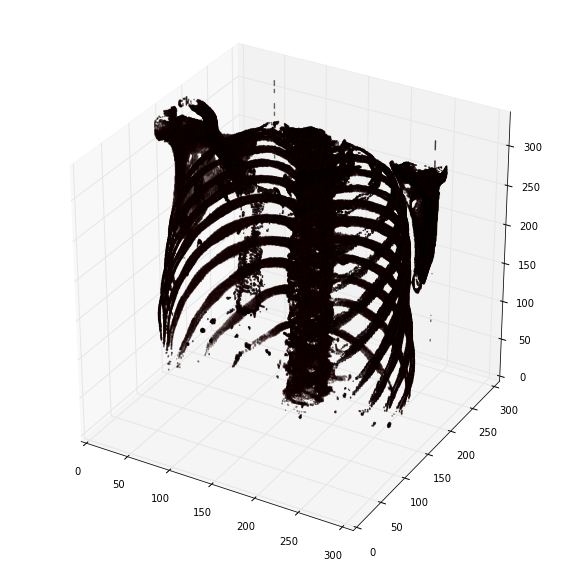

In [9]:
plot_3d(pix_resampled, 400)

Spooky!

# Lung segmentation
In order to reduce the problem space, we can segment the lungs (and usually some tissue around it). The method that me and my student colleagues developed was quite effective. 

It involves quite a few smart steps. It consists of a series of applications of region growing and morphological operations. In this case, we will use only connected component analysis.

The steps:  

* Threshold the image (-320 HU is a good threshold, but it doesn't matter much for this approach)
* Do connected components, determine label of air around person, fill this with 1s in the binary image
* Optionally: For every axial slice in the scan, determine the largest solid connected component (the body+air around the person), and set others to 0. This fills the structures in the lungs in the mask.
* Keep only the largest air pocket (the human body has other pockets of air here and there).

In [10]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

def segment_lung_mask(image, fill_lung_structures=True):
    
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)
    
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    background_label = labels[0,0,0]
    
    #Fill the air around the person
    binary_image[background_label == labels] = 2
    
    
    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
 
    return binary_image

In [11]:
segmented_lungs = segment_lung_mask(pix_resampled, False)
segmented_lungs_fill = segment_lung_mask(pix_resampled, True)

/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/delaunay/triangulate.py:104: DuplicatePointWarning: Input data contains duplicate x,y points; some values are ignored.
  DuplicatePointWarning,


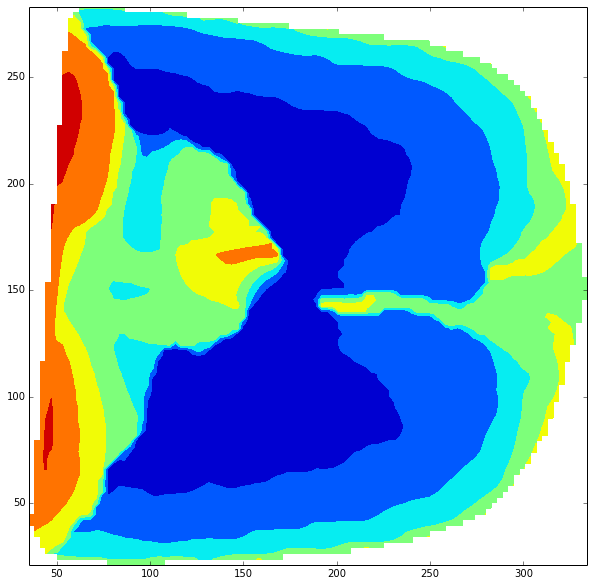

In [12]:
plot_contour(segmented_lungs.transpose(1, 2, 0), 0)

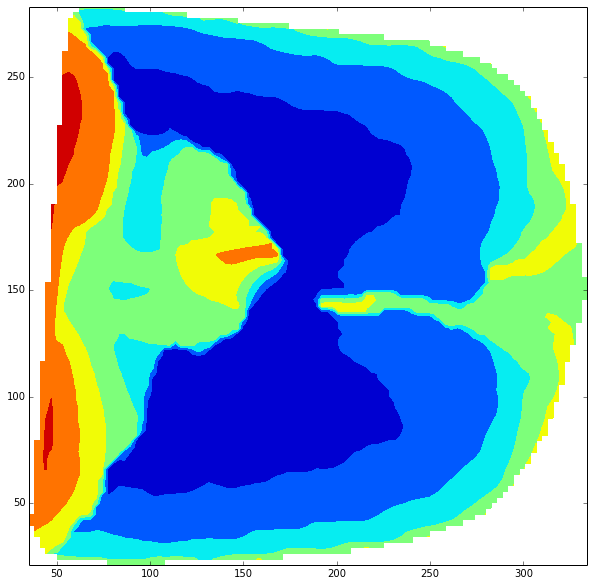

In [13]:
plot_contour(segmented_lungs_fill.transpose(1, 2, 0), 0)

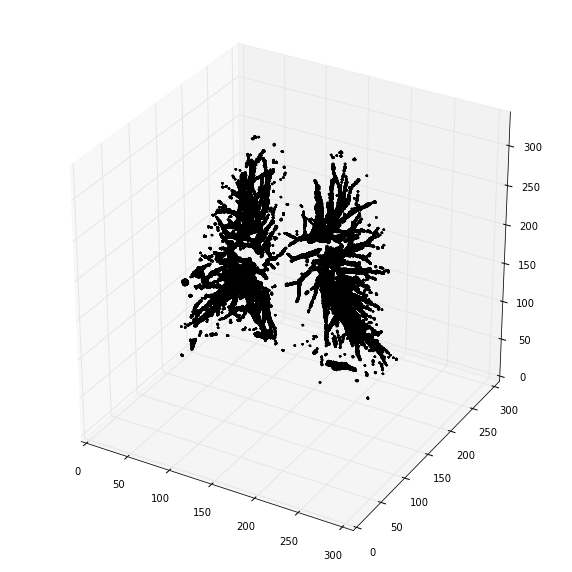

In [14]:
plot_3d_mcubes(segmented_lungs_fill - segmented_lungs, 0)

In [15]:
MIN_BOUND = -1000.0
MAX_BOUND = 400.0

def normalize(image):
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image

In [16]:
pix_norm = normalize(pix_resampled)

In [17]:
segmented_lungs_fill.shape

(335, 306, 306)

In [18]:
segmented_lungs_fill = segmented_lungs_fill.astype(bool)

In [19]:
pix_norm.shape

(335, 306, 306)

In [20]:
pix_norm2 = np.copy(pix_norm)
pix_norm2[np.logical_not(segmented_lungs_fill)] = 0

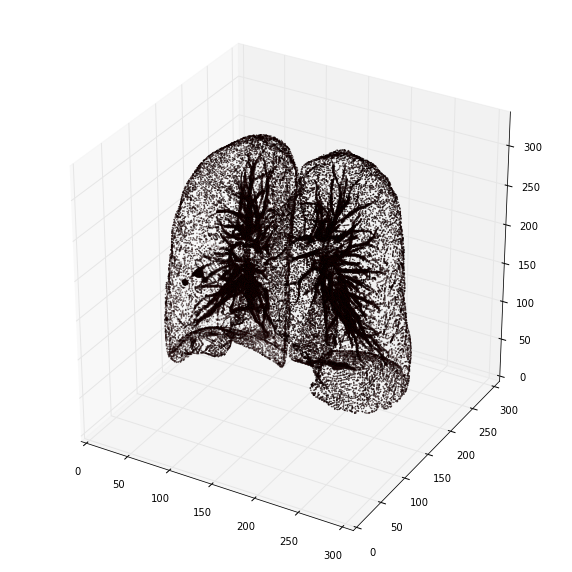

In [21]:
plot_3d(pix_norm2, 0.45)

In [22]:
pix = []

for i in range(0, len(patients)):
    patient = load_scan(INPUT_FOLDER + patients[i])
    patient_pixels = get_pixels_hu(patient)
    pix_resampled, spacing = resample(patient_pixels, patient, [1,1,1])
    print (pix_resampled.shape)
    mask = segmented_lungs = segment_lung_mask(pix_resampled, fill_lung_structures=True)
    pix_norm = normalize(pix_resampled)
    pix_norm[np.logical_not(mask)] = 0
    print (np.mean(pix_norm))
    
    if np.mean(pix_norm) > 0.008:
        pix.append(pix_norm)
pix = np.array(pix)


(335, 306, 306)
0.0202717808451
(320, 347, 347)
0.0221110295356
(332, 340, 340)
0.0183690255771
(275, 320, 320)
0.0246724901836
(365, 279, 279)
0.00301976533981
(353, 360, 360)
0.0131652758574
(350, 340, 340)
0.0148369785679
(308, 355, 355)
0.0184425803955
(328, 360, 360)
0.0158512665613
(305, 390, 390)
0.0187325055315
(272, 330, 330)
0.0265191721454
(360, 350, 350)
0.0148857614998
(398, 309, 309)
0.0173894556494
(294, 300, 300)
0.019870265981
(304, 424, 424)
0.0125336010643
(366, 370, 370)
0.0156100397362
(315, 310, 310)
0.0263910995491
(354, 259, 259)
0.0257210648291
(342, 392, 392)
0.0136670933862
(282, 308, 308)
0.0237117312495


In [23]:
X_train = []
X_lim, Y_lim, Z_lim = 0, 0, 0
for mri in pix:
    x, y, z = mri.shape
    X_lim, Y_lim, Z_lim = max(X_lim, x), max(Y_lim, y), max(Z_lim, z)

print (X_lim, Y_lim, Z_lim)
for mri in pix:
    print ("Initial: ", mri.shape)
    x, y, z = mri.shape
    diff_x, diff_y, diff_z = X_lim - x, Y_lim - y, Z_lim - z
    mri = np.lib.pad(mri, ((diff_x/2, diff_x-diff_x/2), (diff_y/2, diff_y-diff_y/2), (diff_z/2, diff_z-diff_z/2)),
                     'constant', constant_values=0.0)
    print ("Final: ", mri.shape)
    X_train.append(mri)
X_train = np.array(X_train)
    

(398, 424, 424)
('Initial: ', (335, 306, 306))
('Final: ', (398, 424, 424))
('Initial: ', (320, 347, 347))
('Final: ', (398, 424, 424))
('Initial: ', (332, 340, 340))
('Final: ', (398, 424, 424))
('Initial: ', (275, 320, 320))
('Final: ', (398, 424, 424))
('Initial: ', (353, 360, 360))
('Final: ', (398, 424, 424))
('Initial: ', (350, 340, 340))
('Final: ', (398, 424, 424))
('Initial: ', (308, 355, 355))
('Final: ', (398, 424, 424))
('Initial: ', (328, 360, 360))
('Final: ', (398, 424, 424))
('Initial: ', (305, 390, 390))
('Final: ', (398, 424, 424))
('Initial: ', (272, 330, 330))
('Final: ', (398, 424, 424))
('Initial: ', (360, 350, 350))
('Final: ', (398, 424, 424))
('Initial: ', (398, 309, 309))
('Final: ', (398, 424, 424))
('Initial: ', (294, 300, 300))
('Final: ', (398, 424, 424))
('Initial: ', (304, 424, 424))
('Final: ', (398, 424, 424))
('Initial: ', (366, 370, 370))
('Final: ', (398, 424, 424))
('Initial: ', (315, 310, 310))
('Final: ', (398, 424, 424))
('Initial: ', (354, 259,

In [24]:
#various Image<->Image Deep CNN models

import numpy as np

from keras.layers import Input, Dense, Dropout, Reshape, Flatten, merge, TimeDistributed
from keras.layers import Convolution2D, MaxPooling2D, UpSampling2D, ZeroPadding2D, SpatialDropout2D, Cropping2D
from keras.models import Model, load_model
from keras.optimizers import SGD, adadelta
from keras.callbacks import ProgbarLogger, RemoteMonitor, ReduceLROnPlateau, ModelCheckpoint

from keras import backend as K

input_img = Input(shape=(398, 424, 424))
map_size = 3
x = Reshape((398, 1, 424, 424)) (input_img)
x = TimeDistributed(Convolution2D(map_size, 3, 3, activation='relu', border_mode='same')) (x)
x = TimeDistributed(Convolution2D(map_size, 3, 3, activation='softplus', border_mode='same'))(x)
x = TimeDistributed(MaxPooling2D((2,2), strides=(2,2))) (x)

x = TimeDistributed(Convolution2D(map_size, 3, 3, activation='relu', border_mode='same'))(x)
x = TimeDistributed(Convolution2D(map_size, 3, 3, activation='tanh', border_mode='same'))(x)
x = TimeDistributed(MaxPooling2D((2,2), strides=(2,2))) (x)

x = TimeDistributed(Convolution2D(map_size, 3, 3, activation='tanh', border_mode='same')) (x)
x = TimeDistributed(Convolution2D(map_size, 3, 3, activation='relu', border_mode='same')) (x)
x = TimeDistributed(UpSampling2D((2, 2))) (x)

x = TimeDistributed(Convolution2D(map_size, 3, 3, activation='relu', border_mode='same')) (x)
x = TimeDistributed(Convolution2D(1, 3, 3, activation='relu', border_mode='same')) (x)
x = TimeDistributed(UpSampling2D((2, 2))) (x)
x = TimeDistributed(Convolution2D(1, 3, 3, activation='relu', border_mode='same')) (x)
x = Reshape((398, 424, 424)) (x)

model = Model(input_img, x)
sgd = SGD(lr=1e-2, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='mse', metrics=['mae'])

Couldn't import dot_parser, loading of dot files will not be possible.


Using Theano backend.


In [25]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 398, 424, 424) 0                                            
____________________________________________________________________________________________________
reshape_1 (Reshape)              (None, 398, 1, 424, 4 0           input_1[0][0]                    
____________________________________________________________________________________________________
timedistributed_1 (TimeDistribut (None, 398, 3, 424, 4 30          reshape_1[0][0]                  
____________________________________________________________________________________________________
timedistributed_2 (TimeDistribut (None, 398, 3, 424, 4 84          timedistributed_1[0][0]          
___________________________________________________________________________________________

In [26]:
model.fit(X_train, X_train, batch_size=1)

Epoch 1/10
19/19 [==============================] - 1934s - loss: 0.0020 - mean_absolute_error: 0.0146    
Epoch 2/10
19/19 [==============================] - 2007s - loss: 0.0019 - mean_absolute_error: 0.0191    
Epoch 3/10
19/19 [==============================] - 2023s - loss: 0.0019 - mean_absolute_error: 0.0177    
Epoch 4/10
19/19 [==============================] - 1991s - loss: 0.0019 - mean_absolute_error: 0.0178    
Epoch 5/10
19/19 [==============================] - 2031s - loss: 0.0019 - mean_absolute_error: 0.0180    
Epoch 6/10
19/19 [==============================] - 1947s - loss: 0.0019 - mean_absolute_error: 0.0179    
Epoch 7/10
19/19 [==============================] - 1960s - loss: 0.0019 - mean_absolute_error: 0.0177    
Epoch 8/10
19/19 [==============================] - 1952s - loss: 0.0019 - mean_absolute_error: 0.0183    
Epoch 9/10
19/19 [==============================] - 1933s - loss: 0.0019 - mean_absolute_error: 0.0176    
Epoch 10/10
10/19 [==============>...

KeyboardInterrupt: 

In [27]:
X_pred = model.predict(X_train[0:1])

In [29]:
X_pred = X_pred[0]

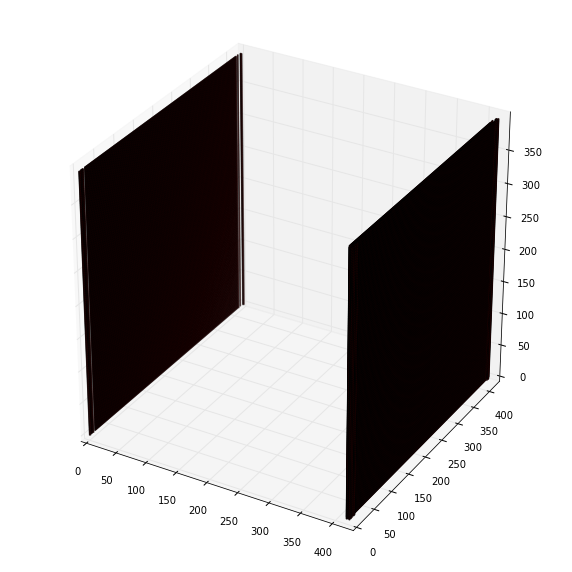

In [42]:
plot_3d(X_pred, 0.01)